In [5]:
import os
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scprep
from sklearn.neighbors import kneighbors_graph

In [6]:
import helpers

In [7]:
merged_metadata, relatedness, genotypes_array, mapping_info = helpers.load_data()

In [9]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import numpy as np
from sklearn.metrics.pairwise import haversine_distances

def haversine_vectorized(coords):
    """
    Compute pairwise haversine distances in a vectorized manner.
    coords: (n_samples, 2) array of [latitude, longitude] in radians.
    Returns:
        Square pairwise distance matrix.
    """
    lat = coords[:, 0][:, np.newaxis]  # Reshape for broadcasting
    lon = coords[:, 1][:, np.newaxis]

    # Compute differences
    dlat = lat - lat.T
    dlon = lon - lon.T

    # Haversine formula
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat) * np.cos(lat.T) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Earth's radius (6371 km)
    distances = 6371 * c

    return distances

def preservation_metric(gt_dists, ac_dists, num_dists=50000):
    """
    Compute the Spearman correlation between two pairwise distance matrices.
    gt_dists: Ground truth condensed distance matrix.
    ac_dists: Ancestry condensed distance matrix.
    num_samples: Number of distances to sample for Spearman correlation.
    """
    # Take a random subset of distances for Spearman correlation
    subset = np.random.choice(len(ac_dists), min(num_dists, len(ac_dists)), replace=False)

    # Compute Spearman correlation
    corr, _ = spearmanr(gt_dists[subset], ac_dists[subset], axis=0)
    return corr


def compute_geographic_metric(ancestry_coords, merged_metadata):
    # geography doesn't mean anything for these populations
    include_index = (merged_metadata['Genetic_region_merged'] == 'America') | merged_metadata['Population'].isin(['ACB', 'ASW', 'CEU'])
    ground_truth_coords = merged_metadata[['latitude', 'longitude']]
    ground_truth_coords = np.radians(ground_truth_coords)
    
    ancestry_dists = pdist(ancestry_coords[include_index])
    ground_truth_coords_rad = np.radians(ground_truth_coords[include_index])
    ground_truth_dists_square = haversine_vectorized(ground_truth_coords_rad.values)
    ground_truth_dists = squareform(ground_truth_dists_square)

    geographic_preservation = preservation_metric(ground_truth_dists, 
                                                  ancestry_dists)
    return geographic_preservation


def compute_knn_laplacian(ancestry_coords, k=5, normalized=True):
    """
    Compute the graph Laplacian for a KNN graph based on ancestry coordinates.

    Parameters:
    ancestry_coords (numpy.ndarray): An (N, D) array of ancestry coordinates (N samples, D dimensions).
    k (int): Number of nearest neighbors for the KNN graph.
    normalized (bool): Whether to compute the normalized Laplacian. If False, returns the unnormalized Laplacian.

    Returns:
    laplacian (numpy.ndarray): The graph Laplacian matrix (N, N).
    """
    # Create a KNN graph (returns adjacency matrix)
    adjacency = kneighbors_graph(ancestry_coords, n_neighbors=k, mode='connectivity', include_self=False)
    adjacency = adjacency.toarray()

    # Degree matrix
    degree_matrix = np.diag(adjacency.sum(axis=1))

    if normalized:
        # Compute the normalized Laplacian
        degree_inv_sqrt = np.linalg.inv(np.sqrt(degree_matrix))
        laplacian = np.eye(adjacency.shape[0]) - degree_inv_sqrt @ adjacency @ degree_inv_sqrt
    else:
        # Compute the unnormalized Laplacian
        laplacian = degree_matrix - adjacency

    return laplacian

def compute_average_smoothness(laplacian, admixture_ratios):
    """
    Compute the average smoothness of admixture ratios over a graph.

    Parameters:
    laplacian (numpy.ndarray): The graph Laplacian matrix (N, N).
    admixture_ratios (numpy.ndarray): An (N, C) array of admixture ratios (N samples, C components).

    Returns:
    average_smoothness (float): The average smoothness over all components.
    """
    smoothness_values = []
    for i in range(admixture_ratios.shape[1]):  # Iterate over components
        x = admixture_ratios[:, i]
        smoothness = np.dot(x.T, np.dot(laplacian, x))  # x^T L x
        smoothness_values.append(smoothness)
    
    return np.mean(smoothness_values)

# laplacian eigenmap approach
def compute_continental_admixture_metric(ancestry_coords, admixture_ratios):
    # Compute Laplacian
    laplacian = compute_knn_laplacian(ancestry_coords, k=5)

    # Compute average smoothness
    average_smoothness = compute_average_smoothness(laplacian, admixture_ratios)

    return average_smoothness

# Just computes spearman corr between admixture distance and embedding distances
def compute_continental_admixture_metric_dists(ancestry_coords, admixture_ratios):
    ancestry_dists = pdist(ancestry_coords)
    admixture_dists = pdist(admixture_ratios)
    admixture_preservation = preservation_metric(admixture_dists, 
                                                 ancestry_dists)
    
    return admixture_preservation


def compute_metrics(ancestry_coords, merged_metadata, admixture_ratios):
    
    # filter out bad samples
    to_keep = ~merged_metadata['filter_pca_outlier'] & ~merged_metadata['hard_filtered'] & ~merged_metadata['filter_contaminated']
    ancestry_coords = ancestry_coords[to_keep]
    admixture_ratios = admixture_ratios[to_keep]
    merged_metadata = merged_metadata[to_keep]
    
    
    geographic_preservation = compute_geographic_metric(ancestry_coords, merged_metadata)
    admixture_preservation = compute_continental_admixture_metric(ancestry_coords, admixture_ratios)
    admixture_preservation_dists = compute_continental_admixture_metric_dists(ancestry_coords, admixture_ratios)

    out_str = 'Preservation Metrics. Geo : {:.2f}. Admix (dists): {:.2f}. Admix (Laplacian): {:.2f}'.format(geographic_preservation, 
                                                                                                            admixture_preservation_dists,
                                                                                                            admixture_preservation,
                                                                                                           )
    return out_str

In [10]:
# Step 0: Pre-process data
normalized_matrix, overlap_counts = helpers.preprocess_data_matrix(genotypes_array)

Loading previously computed non-missing overlap matrix...


In [11]:
# Fit PCA model on unrelated samples
filters = ["filter_pca_outlier", "hard_filtered", "filter_contaminated"]
_filtered_indices = merged_metadata[merged_metadata[filters].any(axis=1)].index
filtered_indices = ~merged_metadata.index.isin(_filtered_indices)
related_indices = ~merged_metadata['filter_king_related'].values #np.ones(shape=genotypes_array.shape[0], dtype=bool)

to_fit_on = related_indices & filtered_indices
to_transform_on = (~related_indices) & filtered_indices

In [12]:
pca_emb, pca_obj = helpers.compute_pca_from_data_matrix(normalized_matrix,
                                                         to_fit_on,
                                                         to_transform_on,
                                                         n_components=50)

In [13]:
phate_emb = helpers.compute_phate(pca_emb, to_fit_on, to_transform_on, knn=5, t=5)

Running PHATE on 3400 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.30 seconds.
  Calculating affinities...
  Calculated affinities in 0.06 seconds.
Calculated graph and diffusion operator in 0.40 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.15 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.93 seconds.
Calculated landmark operator in 2.79 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.90 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.97 seconds.
Calculating KNN search...
Calculated KNN search in 0.05 seconds.
Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


In [14]:
# fit t-SNE
from sklearn.manifold import TSNE

tsne_obj = TSNE(n_components=2, init='pca')
tsne_emb = np.zeros(shape=(len(pca_emb), 2))
tsne_out = tsne_obj.fit_transform(pca_emb[to_fit_on | to_transform_on])
tsne_emb[to_fit_on | to_transform_on] = tsne_out

## Show Metrics

In [15]:
def plot_admixtures(tsne_emb, phate_emb, admix_ratios):
    num_comp = admix_ratios.shape[1]
    fig, ax = plt.subplots(figsize=(20, 10*num_comp), nrows=num_comp, ncols=2, gridspec_kw={'wspace': 0.08})

    for i in range(num_comp):
        scprep.plot.scatter2d(
            tsne_emb,
            s=20,
            cmap='seismic',
            ax=ax[i, 0],
            c=admix_ratios[:, i],
            xticks=False,
            yticks=False,
            legend=True,
            legend_loc='lower center',
            legend_anchor=(0.5, -0.35),
            legend_ncol=8,
            label_prefix="t-SNE ",
            fontsize=8
        )
        ax[i, 0].set_title("t-SNE of HGDP", fontsize=30)
        try:
            ax[i, 0].get_legend().remove()
        except:
            pass

        scprep.plot.scatter2d(
            phate_emb,
            s=20,
            cmap='seismic',
            ax=ax[i, 1],
            c=admix_ratios[:, i],
            xticks=False,
            yticks=False,
            legend=True,
            legend_loc='lower center',
            legend_anchor=(0.5, -0.35),
            legend_ncol=8,
            label_prefix="PHATE ",
            fontsize=8
        )
        ax[i, 1].set_title("PHATE of HGDP", fontsize=30)
        try:
            ax[i, 1].get_legend().remove()
        except:
            pass

In [16]:
prefix = 'global'
n_comps = 5
admixture_root = '/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4/admixture/ADMIXTURE_HGDP+1KGP'
fname = '{}.{}_metadata.tsv'.format(prefix, n_comps)
admix_ratios = pd.read_csv(os.path.join(admixture_root, fname), sep='\t', header=None)

admixture_ratios_nonzero = admix_ratios.loc[:, 1:n_comps].values
admixture_ratios = np.zeros(shape=(tsne_emb.shape[0], 
                                   admixture_ratios_nonzero.shape[1]))

index = to_fit_on | to_transform_on
admixture_ratios[index] = admixture_ratios_nonzero

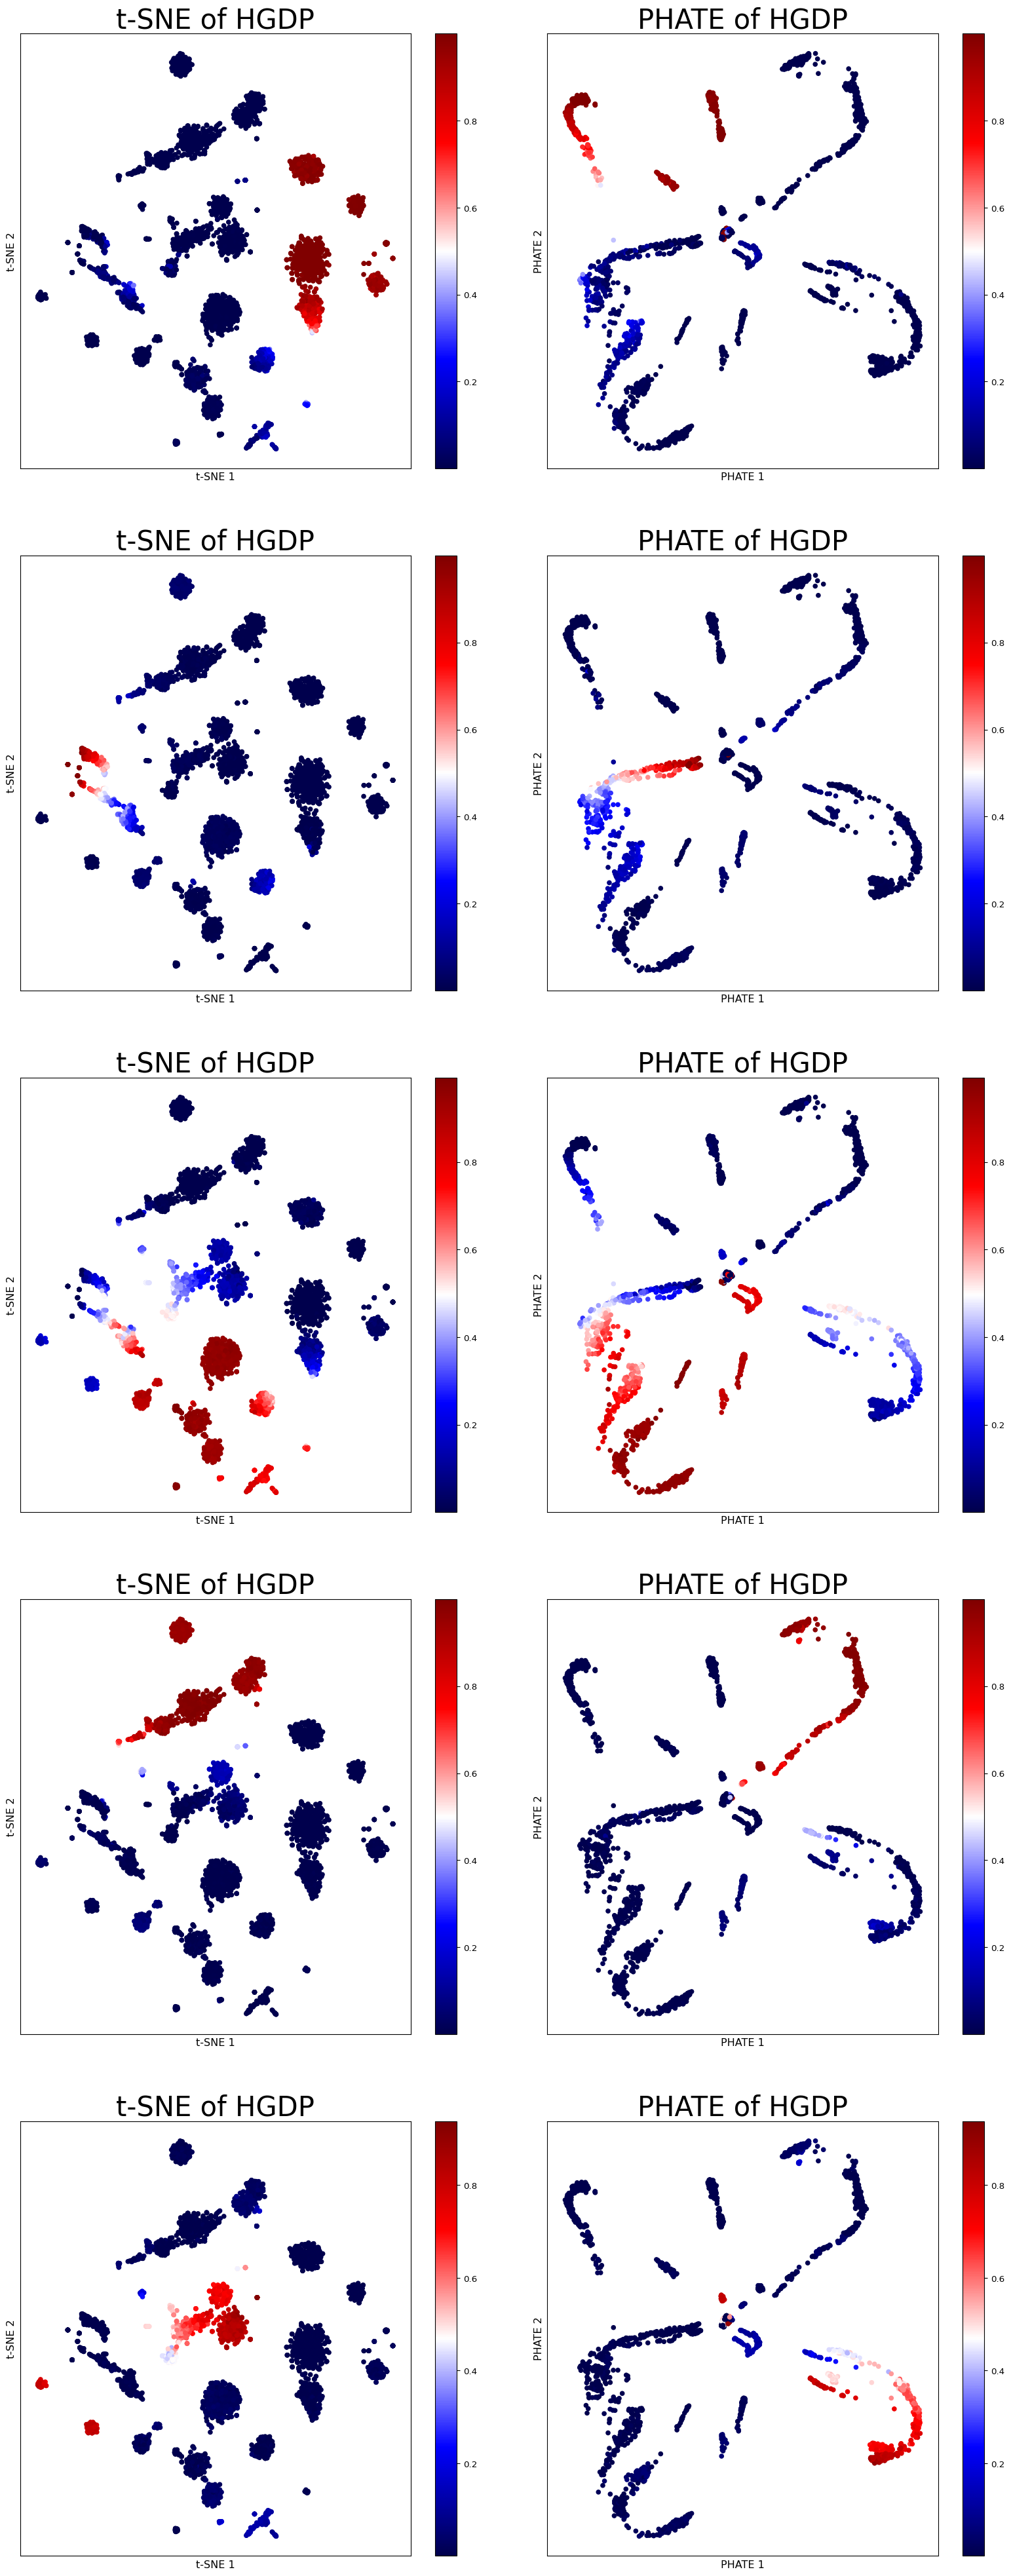

In [17]:
plot_admixtures(tsne_emb[index], 
                phate_emb[index], 
                admixture_ratios[index])

In [18]:
print('PCA (50D): ' + compute_metrics(pca_emb, 
                                      merged_metadata, 
                                      admixture_ratios))
print('PCA (2D): ' + compute_metrics(pca_emb[:,:2], 
                                     merged_metadata, 
                                     admixture_ratios))
print('t-SNE: ' + compute_metrics(tsne_emb, 
                                  merged_metadata, 
                                  admixture_ratios))
print('PHATE: ' + compute_metrics(phate_emb, 
                                  merged_metadata, 
                                  admixture_ratios))

PCA (50D): Preservation Metrics. Geo : 0.33. Admix (dists): 0.85. Admix (Laplacian): -0.93
PCA (2D): Preservation Metrics. Geo : 0.29. Admix (dists): 0.88. Admix (Laplacian): 12.57
t-SNE: Preservation Metrics. Geo : 0.34. Admix (dists): 0.59. Admix (Laplacian): 0.25
PHATE: Preservation Metrics. Geo : 0.40. Admix (dists): 0.53. Admix (Laplacian): 6.11


In [19]:
from sklearn.random_projection import GaussianRandomProjection
projector = GaussianRandomProjection(n_components=2000, random_state=42)
reduced_genotype_matrix = projector.fit_transform(normalized_matrix)
pca_embr, pca_objr = helpers.compute_pca_from_data_matrix(reduced_genotype_matrix,
                                                         to_fit_on,
                                                         to_transform_on,
                                                         n_components=50)
phate_embr = helpers.compute_phate(pca_embr, to_fit_on, to_transform_on, knn=5, t=5)

Running PHATE on 3400 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.43 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.46 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.17 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.04 seconds.
Calculated landmark operator in 1.94 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.87 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.68 seconds.
Calculating KNN search...
Calculated KNN search in 0.09 seconds.
Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


In [20]:
tsne_obj2 = TSNE(n_components=2, init='pca')
tsne_embr = np.zeros(shape=(len(pca_embr), 2))
tsne_outr = tsne_obj2.fit_transform(pca_embr[to_fit_on | to_transform_on])
tsne_embr[to_fit_on | to_transform_on] = tsne_outr

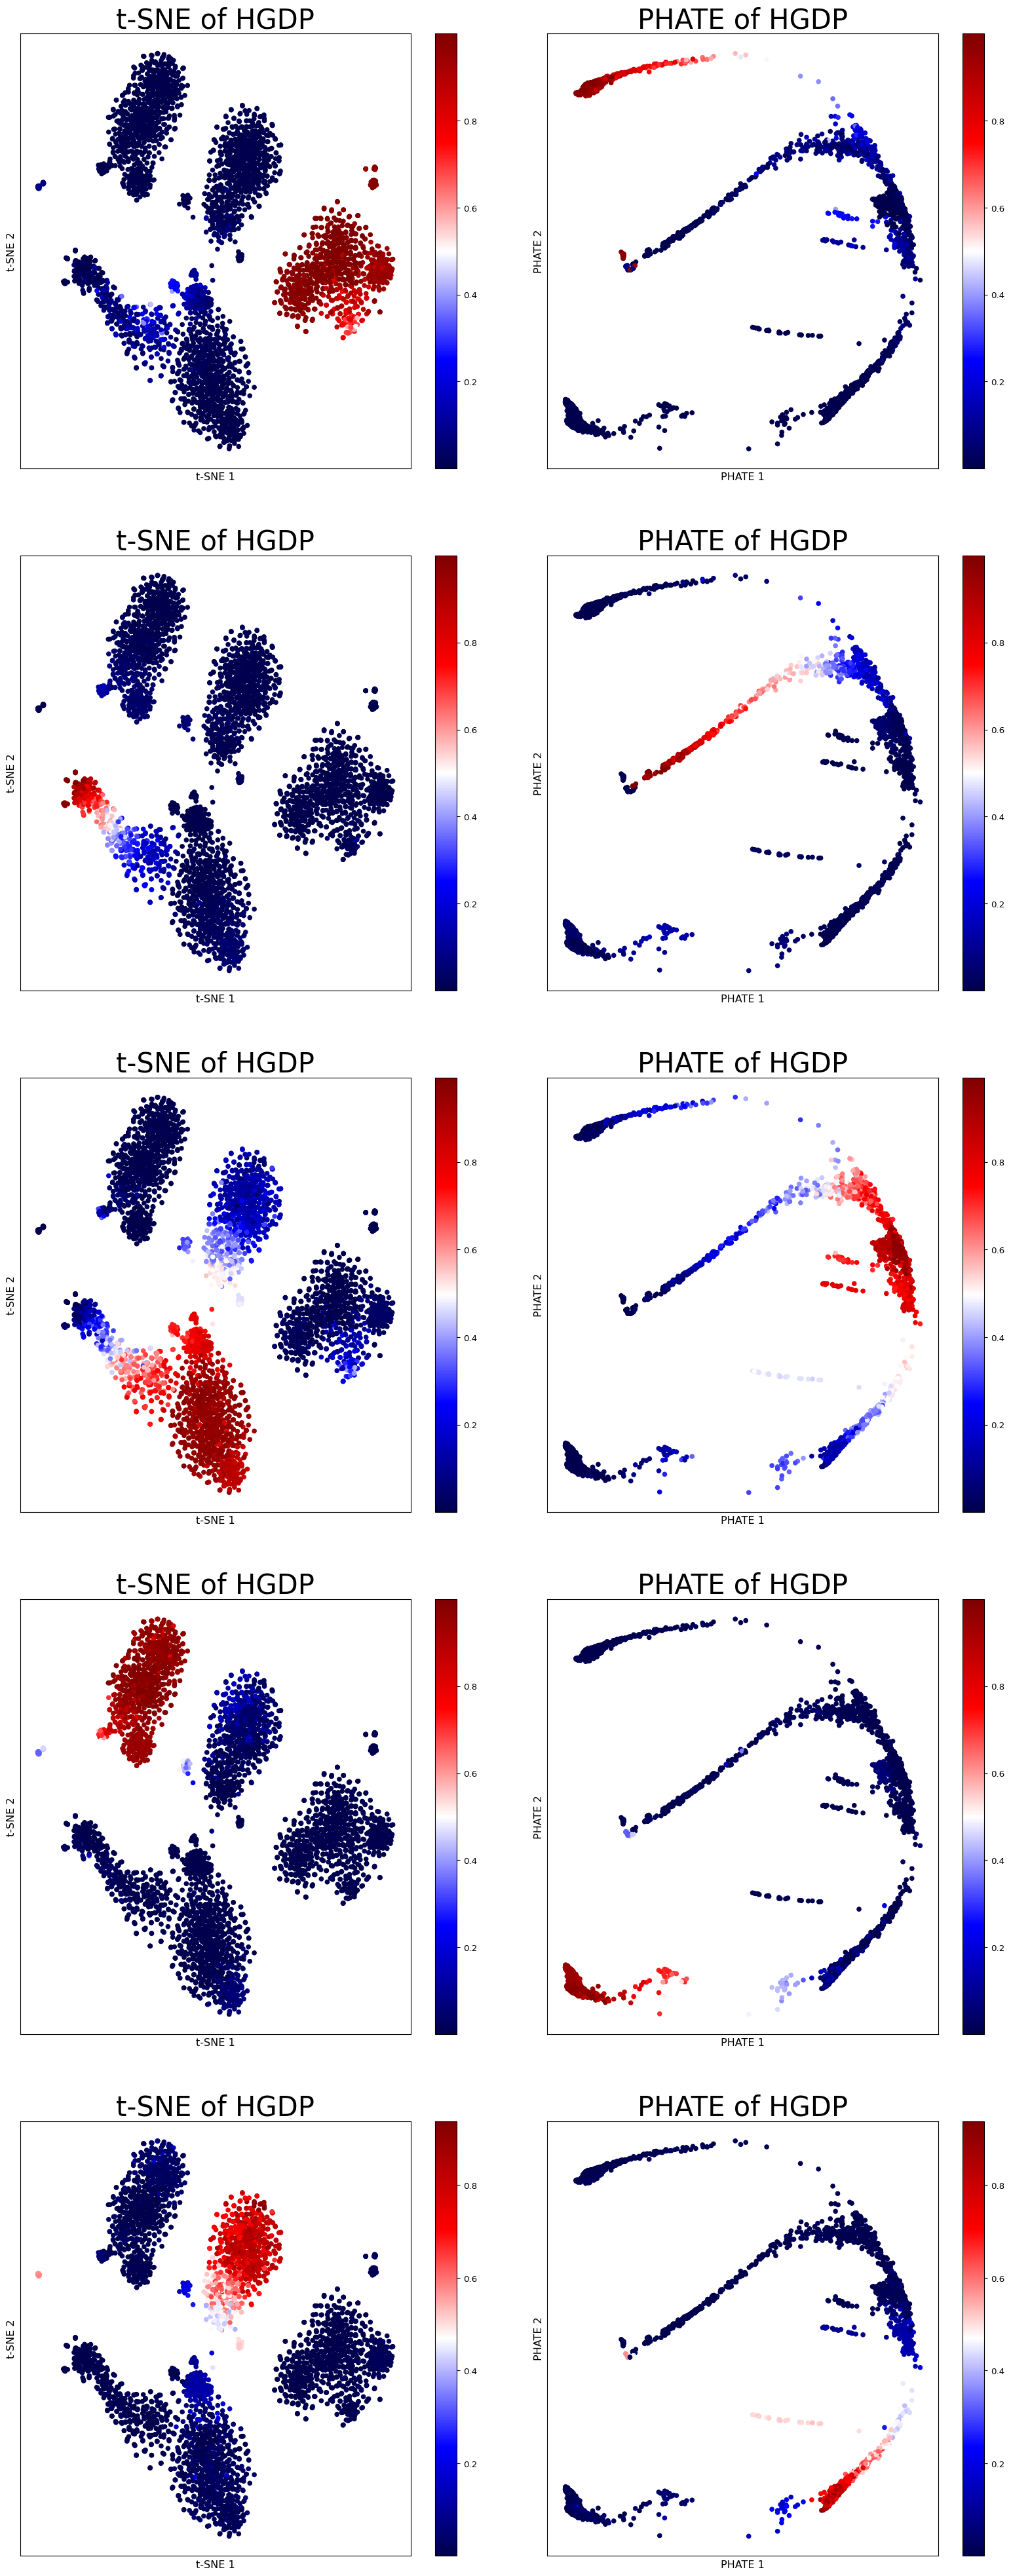

In [21]:
plot_admixtures(tsne_embr[index], 
                phate_embr[index], 
                admixture_ratios[index])

In [22]:
print('PCA (50D): ' + compute_metrics(pca_embr, 
                                      merged_metadata, 
                                      admixture_ratios))
print('PCA (2D): ' + compute_metrics(pca_embr[:,:2], 
                                     merged_metadata, 
                                     admixture_ratios))
print('t-SNE: ' + compute_metrics(tsne_embr, 
                                  merged_metadata, 
                                  admixture_ratios))
print('PHATE: ' + compute_metrics(phate_embr, 
                                  merged_metadata, 
                                  admixture_ratios))

PCA (50D): Preservation Metrics. Geo : 0.30. Admix (dists): 0.84. Admix (Laplacian): -1.32
PCA (2D): Preservation Metrics. Geo : 0.28. Admix (dists): 0.87. Admix (Laplacian): 31.86
t-SNE: Preservation Metrics. Geo : 0.33. Admix (dists): 0.68. Admix (Laplacian): 2.52
PHATE: Preservation Metrics. Geo : 0.25. Admix (dists): 0.76. Admix (Laplacian): 2.78


In [23]:
for i in range(5):
    print('{} PHATE: '.format(i) + compute_metrics(phate_embr, 
                                      merged_metadata, 
                                      admixture_ratios[:, i:i+1]))

for i in range(4):    
    print('{} t-SNE: '.format(i) + compute_metrics(tsne_embr, 
                                      merged_metadata, 
                                      admixture_ratios[:, i:i+1]))

0 PHATE: Preservation Metrics. Geo : 0.25. Admix (dists): 0.44. Admix (Laplacian): 2.15
1 PHATE: Preservation Metrics. Geo : 0.24. Admix (dists): -0.05. Admix (Laplacian): 2.26
2 PHATE: Preservation Metrics. Geo : 0.24. Admix (dists): 0.47. Admix (Laplacian): 5.20
3 PHATE: Preservation Metrics. Geo : 0.25. Admix (dists): 0.41. Admix (Laplacian): 1.92
4 PHATE: Preservation Metrics. Geo : 0.24. Admix (dists): 0.14. Admix (Laplacian): 2.36
0 t-SNE: Preservation Metrics. Geo : 0.34. Admix (dists): 0.35. Admix (Laplacian): 2.55
1 t-SNE: Preservation Metrics. Geo : 0.33. Admix (dists): 0.20. Admix (Laplacian): 0.72
2 t-SNE: Preservation Metrics. Geo : 0.34. Admix (dists): 0.31. Admix (Laplacian): 5.63
3 t-SNE: Preservation Metrics. Geo : 0.33. Admix (dists): 0.39. Admix (Laplacian): 1.69
